In [1]:
import sys
sys.path.append('../')

from src.m4_generator import M4Generator
from src.m4_data_loader import M4DataLoader
from src.training_loss_functions import *
from src.m4_evaluation_loss_functions import *
from src.visualization import *
from src.evaluation import *
from src.m4_model import M4Model


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


# Load Data

In [2]:
EPOCHS = 100
BATCH_SIZE = 120
LOOKBACK = 48
HORIZON = 48
HIDDEN_LAYER_SIZE = 200
FEATURES_NUMBER = 2
OUTPUT_SIZE = HORIZON*2
LOSS = smape

diffAugmentation = DiffAugmentation()
x_augmentations = [diffAugmentation]
y_augmentations = [diffAugmentation]

data_loader = M4DataLoader("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv", 
                           x_augmentations, 
                           y_augmentations,
                           LOOKBACK, HORIZON,  validation_ratio=0.05)

train_x, train_y = data_loader.get_training_data()
test_x, test_y = data_loader.get_test_data()
validate_x, validate_y = data_loader.get_validation_data()
print(train_y.shape)
training_data_generator = M4Generator(train_x, train_y, BATCH_SIZE, FEATURES_NUMBER)
test_data_generator = M4Generator(test_x, test_y, BATCH_SIZE, FEATURES_NUMBER)
validation_data_generator = M4Generator(validate_x, validate_y, BATCH_SIZE, FEATURES_NUMBER)

(6472, 96)


# Train The Model

In [6]:
model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, batch_size=BATCH_SIZE, lookback=LOOKBACK, 
        output_size=OUTPUT_SIZE, learning_rate=0.001, loss = LOSS, dropout_ratio = 0.3, 
        features_number = FEATURES_NUMBER)

model.train(training_data_generator, test_data_generator, epochs=EPOCHS)

hist = model.evaluate(validation_data_generator)
print(hist)

Epoch 1/100
53/53 [==============================] - 13s 249ms/step - loss: 100.3087 - val_loss: 85.5986
Epoch 2/100
53/53 [==============================] - 13s 236ms/step - loss: 81.7378 - val_loss: 79.9541
Epoch 3/100
53/53 [==============================] - 12s 235ms/step - loss: 76.2746 - val_loss: 82.6109
Epoch 4/100
53/53 [==============================] - 12s 234ms/step - loss: 73.7388 - val_loss: 71.7442
Epoch 5/100
53/53 [==============================] - 13s 239ms/step - loss: 71.6494 - val_loss: 64.9054
Epoch 6/100
53/53 [==============================] - 13s 238ms/step - loss: 70.5585 - val_loss: 67.9105
Epoch 7/100
53/53 [==============================] - 13s 252ms/step - loss: 69.4810 - val_loss: 63.8324
Epoch 8/100
53/53 [==============================] - 14s 265ms/step - loss: 68.6553 - val_loss: 66.2238
Epoch 9/100
53/53 [==============================] - 13s 249ms/step - loss: 68.0082 - val_loss: 62.9878
Epoch 10/100
53/53 [==============================] - 13s 247ms

53/53 [==============================] - 13s 239ms/step - loss: 56.1107 - val_loss: 50.8183
Epoch 80/100
53/53 [==============================] - 14s 264ms/step - loss: 55.9309 - val_loss: 51.4872
Epoch 81/100
53/53 [==============================] - 13s 249ms/step - loss: 56.0565 - val_loss: 49.3626
Epoch 82/100
53/53 [==============================] - 13s 252ms/step - loss: 55.9154 - val_loss: 49.5201
Epoch 83/100
53/53 [==============================] - 13s 248ms/step - loss: 55.9907 - val_loss: 48.2336
Epoch 84/100
53/53 [==============================] - 18s 330ms/step - loss: 55.8315 - val_loss: 49.4420
Epoch 85/100
53/53 [==============================] - 13s 250ms/step - loss: 56.0206 - val_loss: 48.4981
Epoch 86/100
53/53 [==============================] - 16s 305ms/step - loss: 55.6446 - val_loss: 48.9535
Epoch 87/100
53/53 [==============================] - 13s 247ms/step - loss: 55.6281 - val_loss: 48.2258
Epoch 88/100
53/53 [==============================] - 12s 232ms/step

# Save The Model

In [7]:
MODEL_BASE_DIR = '../models/point_predictions/1-LSTM'
model.save(MODEL_BASE_DIR)

Saved model files to disk under../models/point_predictions/1-LSTM/5


# Get Best And Worst Predictions

Best Predection Error is     7.5651
Worst Predection Error is   142.8931


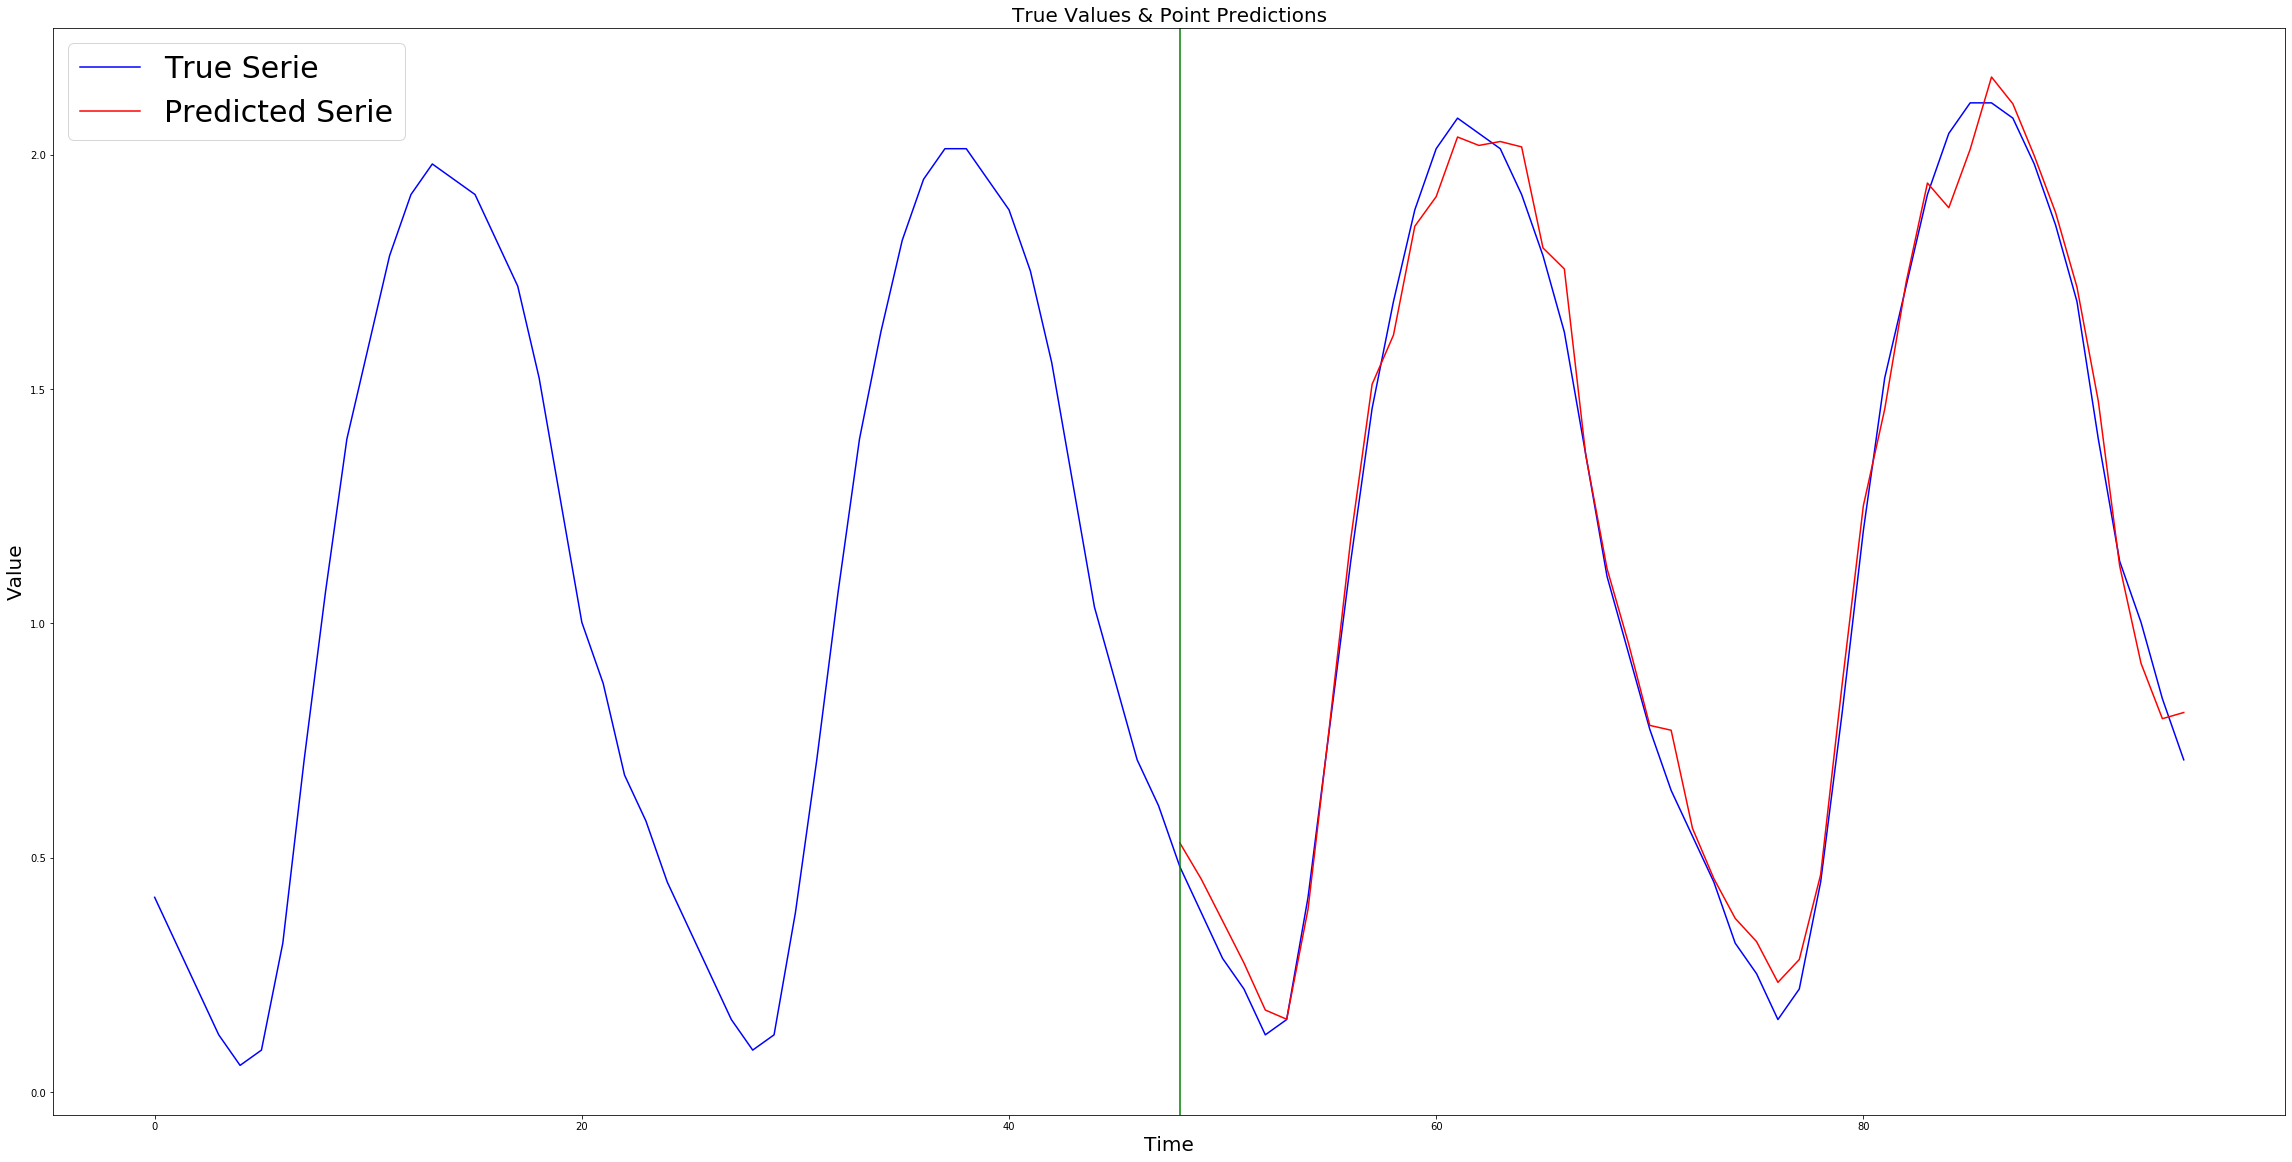

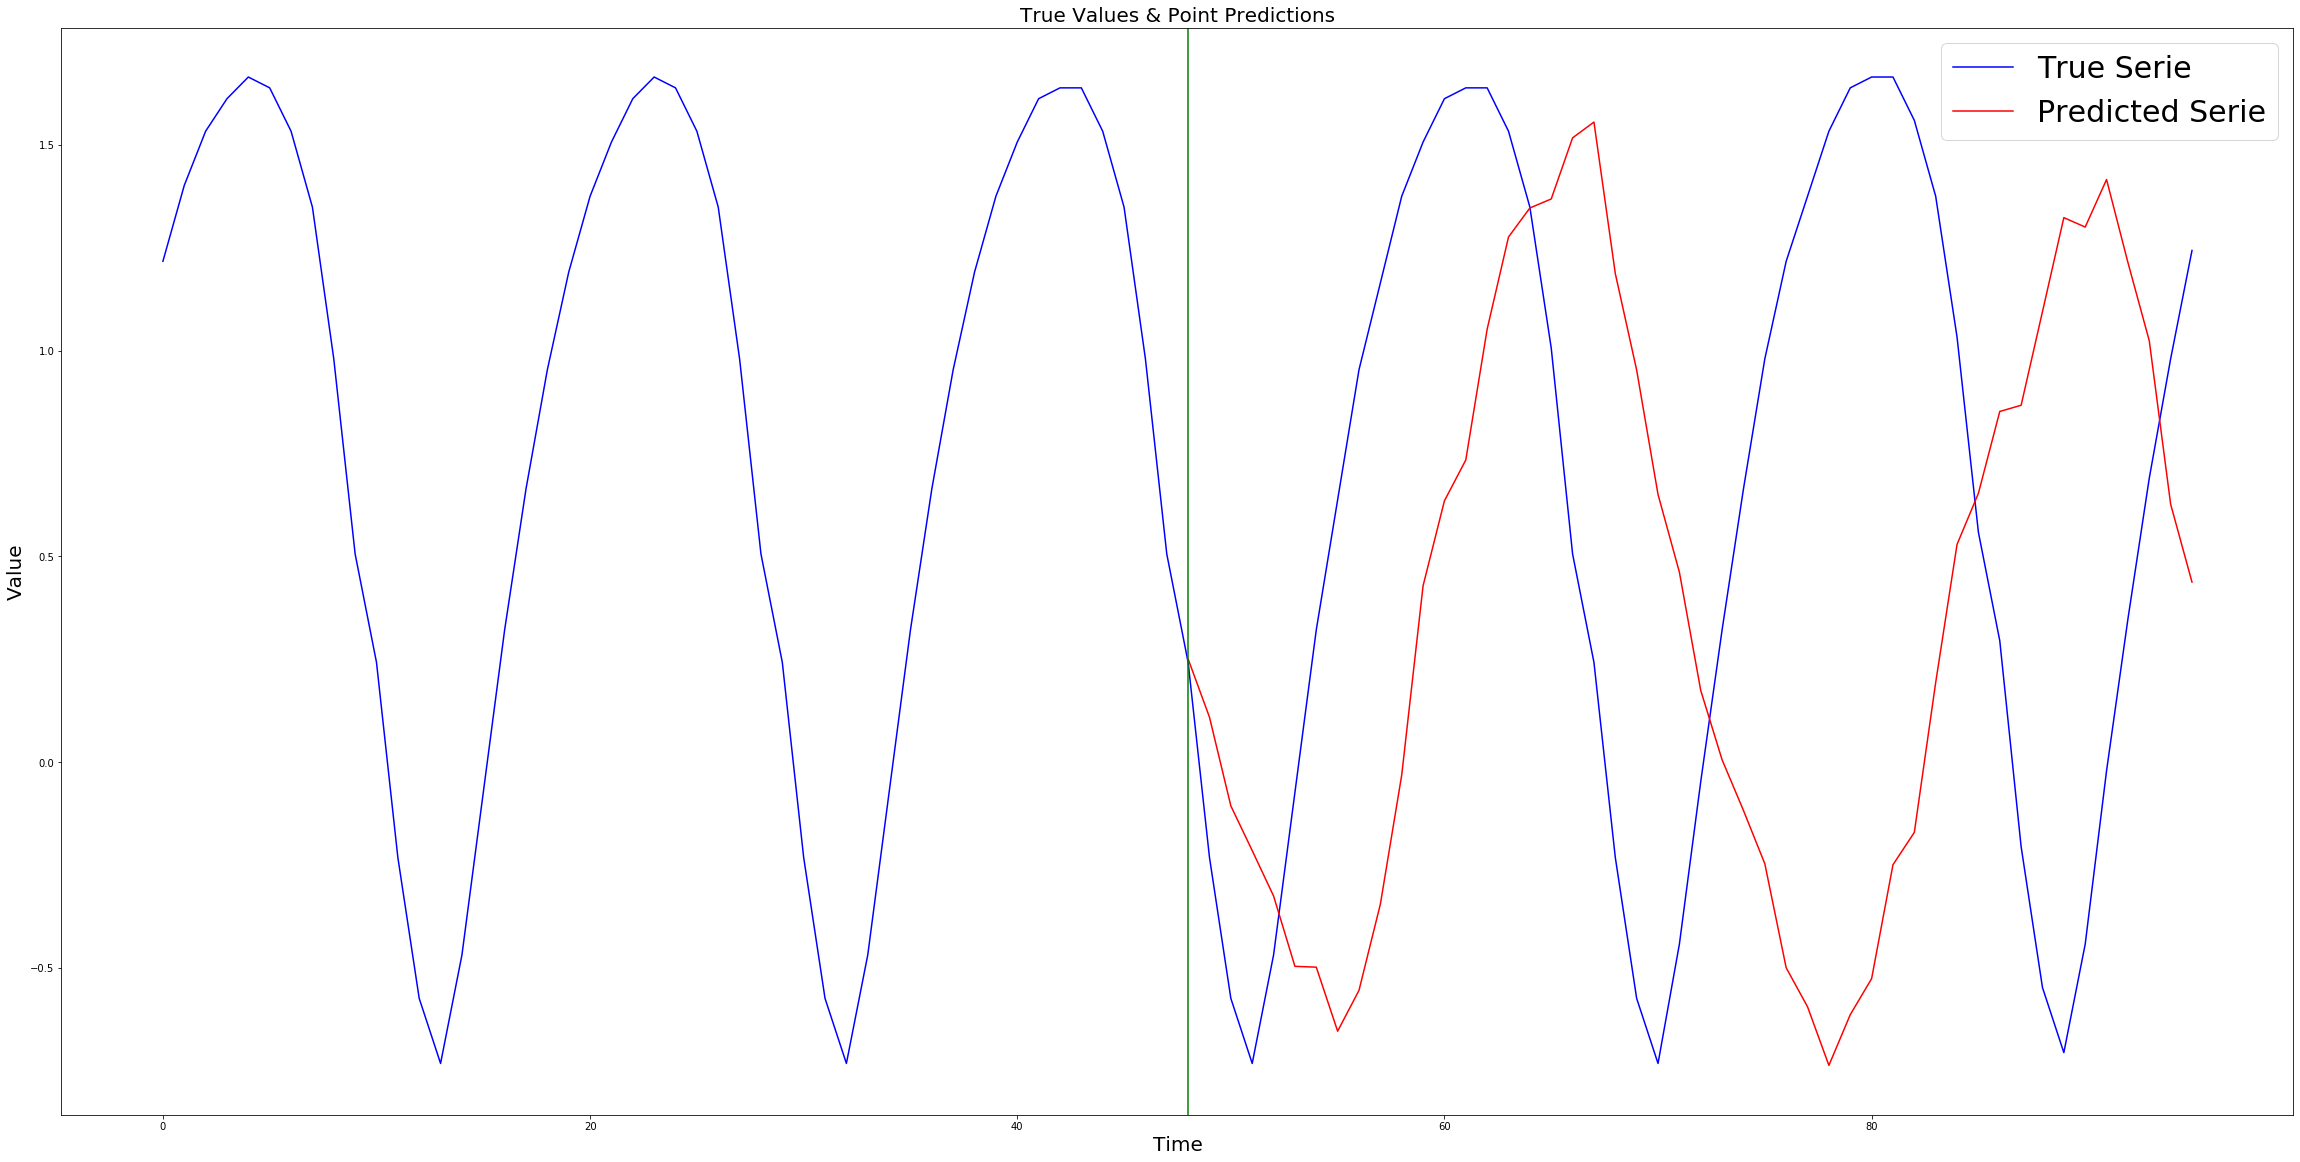

In [9]:
#MODEL_BASE_DIR = '../models/test/1-LSTM/2'
#model = M4Model()
#hyperparameters = model.load(MODEL_BASE_DIR)
    
X, Y, Ypredictions, error =  sort_by_prediction_error(model,test_x, test_y, smape)

if FEATURES_NUMBER == 1:
    X = X[:,:, np.newaxis]

print(f'Best Predection Error is {error[0]:10.4f}')
print(f'Worst Predection Error is {error[X.shape[0]-1]:10.4f}')

plot_serie_and_prediction(X[:,:,0], Y[:,:HORIZON], Ypredictions[:,:HORIZON], serie_indx=0)
plot_serie_and_prediction(X[:,:,0], Y[:,:HORIZON], Ypredictions[:,:HORIZON], serie_indx=X.shape[0]-1)

# PLot Specific Serie From Test Set

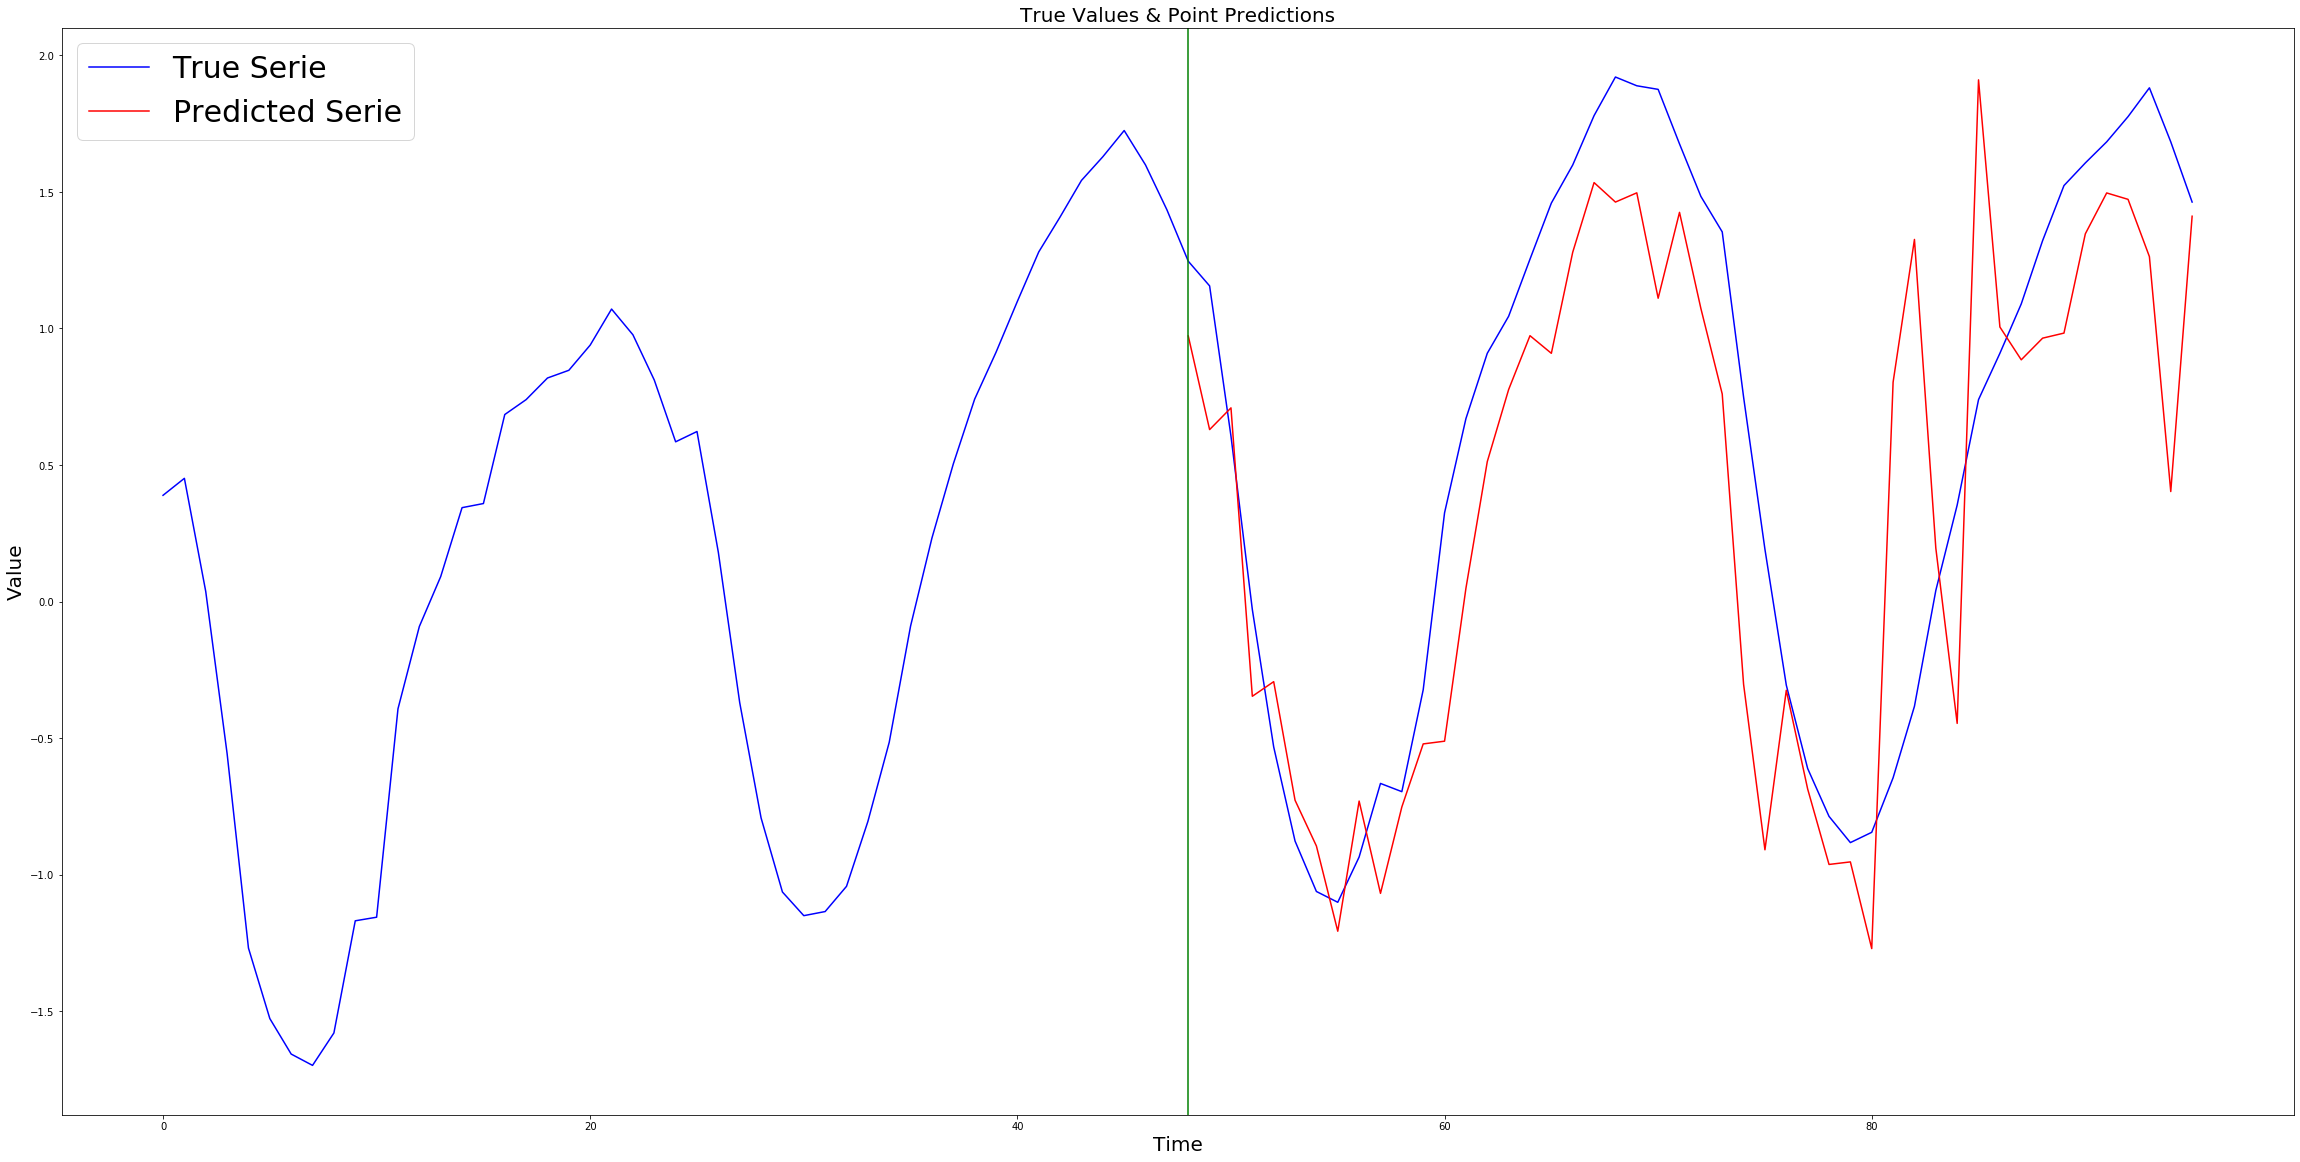

In [34]:
IDX = 40
X = test_x
Y = test_y
predictedY = model.predict(X)

if FEATURES_NUMBER == 1:
    X = X[:,:, np.newaxis]

#============ Predict Test
plot_serie_and_prediction(X[:,:,0], Y[:,:HORIZON], predictedY[:,:HORIZON], serie_indx=IDX)

# Evaluate A Model Against An Error Function

In [4]:
MODEL_NUMBER = 5
MODEL_BASE_DIR = '../models/point_predictions/1-LSTM'
evaluation_results = load_and_evaluate_model(f'{MODEL_BASE_DIR}/{MODEL_NUMBER}', '../Dataset/Train/Hourly-train.csv', 
                                             '../Dataset/Test/Hourly-test.csv', 
                                             x_augmentations, 
                                             y_augmentations, m4_mase)

print(f'Hyperparameters : {evaluation_results["hyperparameters"]}')
print(f'Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["test_error"]}')
print(f'Naive Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["naive_test_error"]}')
      
print(f'SNaive Test Error For Model ({MODEL_NUMBER}) : {evaluation_results["snaive_test_error"]}')

print(f'Validation Error For Model ({MODEL_NUMBER}) : {evaluation_results["validation_error"]}')
print(f'Naive Validation Error For Model ({MODEL_NUMBER}) : {evaluation_results["naive_validation_error"]}')
print(f'SNaive Validation Error For Model ({MODEL_NUMBER}) : {evaluation_results["snaive_validation_error"]}')


Loaded model from disk
Hyperparameters : {'epochs': 100, 'learning_rate': 0.001, 'batch_size': 120, 'hidden_layer_size': 200, 'lookback': 48, 'loss': 'smape', 'dropout_ratio': 0.3, 'features_number': 2, 'output_size': 96, 'pi_params': {}}
Test Error For Model (5) : 2.261
Naive Test Error For Model (5) : 20.57
SNaive Test Error For Model (5) : 1.775
Validation Error For Model (5) : 1.51
Naive Validation Error For Model (5) : 3.689
SNaive Validation Error For Model (5) : 1.634
